# Análisis Exploratorio de los Datos

In [1]:
import os
import time
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision import transforms
from collections import defaultdict
from torchvision.datasets.folder import pil_loader
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
from skimage import io, transform

pd.set_option('max_colwidth', 800)

%matplotlib inline

Inicialmente, se hará un análisis explotatorio de los datos. Esta base de datos está compuesta por dos carpetas, train y valid. Además se compone de train_image_paths y valid_image_paths que contiene la ruta de las imágenes radiográficas, y por último, los archivos train_labeled_studies y valid_labeled_studies, que contienen la ruta de cada estudio con su etiqueta correspondiente, según sea positivo (anormal) o negativo (normal).

Al no tener ningún archivo en el que consten la ruta de cada una de las imágenes con su etiqueta correspondiente, se debe crear uno, al que llamaremos train_labeled y valid_labeled. Para esto, se ha hecho un código en el que se etiquete con un 1 las imágenes que en su ruta salga la palabra positivo y con un 0 las que no, siendo estas negativas.

In [47]:
base_dir = "C:\\Users\\paula\\Documents\\Repositorio\\"

train_img_paths_fn = base_dir + "MURA-v1.1\\train_image_paths.csv"
train_labeled_fn = base_dir + "MURA-v1.1\\train_labeled.csv"

valid_img_paths_fn = base_dir + "MURA-v1.1\\valid_image_paths.csv"
valid_labeled_fn = base_dir + "MURA-v1.1\\valid_labeled.csv"

#img_path_numpy = base_dir + "MURA-v1.1\\train"
#img_path = base_dir + "MURA-v1.1\\train"


In [48]:
valid_img_paths_fn

'C:\\Users\\paula\\Documents\\Repositorio\\MURA-v1.1\\valid_image_paths.csv'

In [49]:
train_df = pd.read_csv(train_img_paths_fn, names=['Path'])

# Función para asignar etiquetas 
def assign_label(line):
    if 'positive' in line :
        return 1     
    else:    
        return 0
ya
labels = []

# Abrir el archivo CSV y leer línea por línea
with open(train_img_paths_fn, 'r') as file:
    for line in file:
        label = assign_label(line)  # Asignar etiqueta a cada línea
        labels.append(label)  # Agregar la etiqueta a la lista
        
train_df['Label'] = labels

train_df.to_csv(train_labeled_fn, index=False)

In [50]:
valid_df = pd.read_csv(valid_img_paths_fn, names=['Path'])

# Función para asignar etiquetas 
def assign_label(line):
    if 'positive' in line :
        return 1     
    else:    
        return 0

labels = []

# Abrir el archivo CSV y leer línea por línea
with open(valid_img_paths_fn, 'r') as file:
    for line in file:
        label = assign_label(line)  # Asignar etiqueta a cada línea
        labels.append(label)  # Agregar la etiqueta a la lista
        
valid_df['Label'] = labels

valid_df.to_csv(valid_labeled_fn, index=False)

,Path,Label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png,1
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image4.png,1
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image1.png,1
...,...,...
3192,MURA-v1.1/valid/XR_FINGER/patient11967/study1_negative/image3.png,0
3193,MURA-v1.1/valid/XR_FINGER/patient11967/study1_negative/image4.png,0
3194,MURA-v1.1/valid/XR_FINGER/patient11738/study1_negative/image1.png,0
3195,MURA-v1.1/valid/XR_FINGER/patient11738/study1_negative/image2.png,0


## Cargar Datos

Se leen los archivos que se han creado y se carga su contenido

In [51]:
train_df = pd.read_csv(train_labeled_fn) 
valid_df = pd.read_csv(valid_labeled_fn)

Se procederá a examinar la forma de los marcos de datos

In [52]:
train_df.shape, valid_df.shape

((36808, 2), (3197, 2))

Se dispone de 36808 radiografías para el conjunto de entrenamiento y 3197 radiografías para el conjunto de validación.

Se muestran las 3 primeras filas del DataFrame

In [53]:
train_df.head(3)

,Path,Label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,1


In [54]:
valid_df.head(3)

,Path,Label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png,1


## Análisis

Según el artículo:

La tarea de detección de anormalidades MURA es una tarea de clasificación binaria, donde la entrada es un estudio radiográfico de la extremidad superior (con cada estudio conteniendo una o más vistas (imágenes)) y la salida esperada es una etiqueta binaria y ∈ {0, 1} que indica si el "estudio" es normal o anormal, respectivamente.

El modelo toma como entrada una o más vistas de un estudio de una extremidad superior. En cada vista, una red neuronal convolucional de 169 capas predice la probabilidad de anormalidad. Se calcula la probabilidad global de anormalidad para el estudio tomando la media aritmética de las probabilidades de anormalidad obtenidas por la red para cada imagen. El modelo realiza la predicción binaria de anormal si la probabilidad de anormalidad para el estudio es superior a 0,5.

Así pues, se tiene que hacer predicciones a nivel de estudio, teniendo en cuenta las predicciones de todas las vistas (imágenes) del estudio. Esto puede hacerse tomando la media aritmética de todas las vistas (imágenes) de un determinado estudio.


In [55]:
train_df.head(30)

,Path,Label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,1
5,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image3.png,1
6,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/image1.png,1
7,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/image2.png,1
8,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/image3.png,1
9,MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/image1.png,1


Analizando este marco de datos, se puede ver que las imágenes se anotan en función de si su estudio correspondiente es negativo (normal, 0) o positivo (anormal, 1).

## Trazar algunas radiografías aleatorias del conjunto de entrenamiento y validación

Se convierte los DataFrames en una matriz NumPy

In [75]:
train_mat = train_df.to_numpy()
valid_mat = valid_df.to_numpy()

El código siguiente selecciona aleatoriamente una imagen del conjunto de datos de entrenamiento, muestra la imagen junto con su categoría y etiqueta asociada, proporcionadas por train_mat

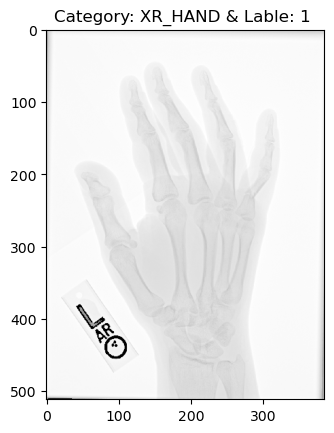

In [80]:
ix = np.random.randint(0, len(train_mat)) # randomly select a index
img_path = base_dir + train_mat[ix][0]
plt.imshow(io.imread(img_path), cmap='binary')
cat = img_path.split('/')[2] # get the radiograph category
plt.title('Category: %s & Lable: %s ' %(cat, train_mat[ix][1]))
plt.show()

In [77]:
img_path

'C:\\Users\\paula\\Documents\\Repositorio\\MURA-v1.1\\train'

In [ ]:
# look at the pixel values
io.imread(img_path)[0]

El código siguiente selecciona aleatoriamente una imagen del conjunto de datos de validación, muestra la imagen junto con su categoría y etiqueta asociada, proporcionadas por valid_mat.

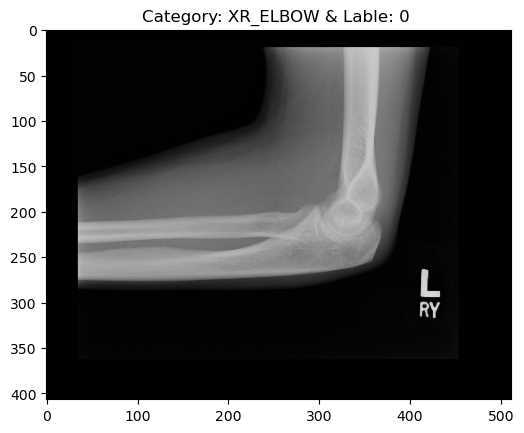

In [81]:
ix = np.random.randint(0, len(valid_mat))
img_path = base_dir + valid_mat[ix][0]
plt.imshow(io.imread(img_path), cmap='binary')
cat = img_path.split('/')[2]
plt.title('Category: %s & Lable: %s ' %(cat, valid_mat[ix][1]))
plt.show()

Se miran los valores de los píxeles

In [ ]:
# look at the pixel values
io.imread(img_path)[0]

### Recuento de pacientes por tipo de estudio

El siguiente código recopila el recuento de pacientes para cada tipo de estudio médico en los conjuntos de datos de entrenamiento y validación. La información se almacena en patients_count.

In [85]:
data_cat= ['train', 'valid']
study_types = list(os.walk(base_dir + 'MURA-v1.1\\train\\'))[0][1] # study types, same for train and valid sets
patients_count = {}  # to store all patients count for each study type, for train and valid sets
for phase in data_cat:
    patients_count[phase] = {}
    for study_type in study_types:
        patients = list(os.walk(base_dir + 'MURA-v1.1\\%s\\%s' %(phase, study_type)))[0][1] # patient folder names
        patients_count[phase][study_type] = len(patients)

Con el primer comando se imprime los tipos de estudios médicos presentes en el conjunto de datos y con segundo comando se imprime el recuento de pacientes para cada tipo de estudio médico en los conjuntos de datos de entrenamiento y validación

In [86]:
print(study_types)
print()
print(patients_count)

['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']

{'train': {'XR_ELBOW': 1711, 'XR_FINGER': 1865, 'XR_FOREARM': 865, 'XR_HAND': 1945, 'XR_HUMERUS': 587, 'XR_SHOULDER': 2694, 'XR_WRIST': 3267}, 'valid': {'XR_ELBOW': 152, 'XR_FINGER': 166, 'XR_FOREARM': 129, 'XR_HAND': 159, 'XR_HUMERUS': 132, 'XR_SHOULDER': 173, 'XR_WRIST': 207}}


El siguiente código crea un gráfico de barras que muestra el recuento de pacientes por tipo de estudio, diferenciando entre los conjuntos de datos de entrenamiento y validación.

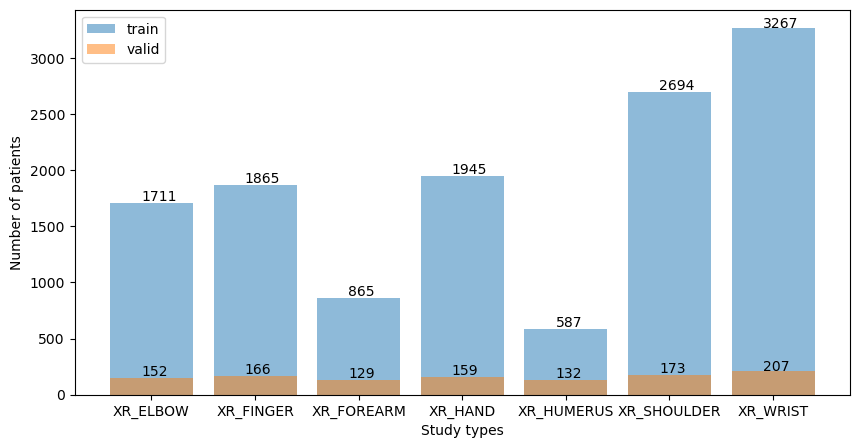

In [87]:
# plot the patient counts per study type 

fig, ax = plt.subplots(figsize=(10, 5))
for i, phase in enumerate(data_cat):
    counts = patients_count[phase].values()
    m = max(counts)
    for i, v in enumerate(counts):
        if v==m: ax.text(i-0.1, v+3, str(v))
        else: ax.text(i-0.1, v + 20, str(v))
    x_pos = np.arange(len(study_types))
    plt.bar(x_pos, counts, alpha=0.5)
    plt.xticks(x_pos, study_types)

plt.xlabel('Study types')
plt.ylabel('Number of patients')
plt.legend(['train', 'valid'])
plt.show()
fig.savefig('images/pcpst.jpg', bbox_inches='tight', pad_inches=0) # name=patient count per study type

### Número de vistas por estudio

Se puede observar que cada estudio puede tener más de una vista (imagen radiográfica). El código siguiente cálcula la cantidad de vistas que tiene cada estudio.

In [89]:
# let's find out number of studies per study_type
view_count = {} # to store study counts for each study type, study count = number of patients which have similar number of studies 
for study_type in study_types:
    BASE_DIR = base_dir + r'\MURA-v1.1\\train\\%s\\' % study_type
    view_count[study_type] = defaultdict(lambda:0) # to store study count for current study_type, initialized to 0 by default
    patients = list(os.walk(BASE_DIR))[0][1] # patient folder names
    for patient in patients:
        studies = os.listdir(BASE_DIR + patient)
        for study in studies:
            views = os.listdir(BASE_DIR + patient + '/' + study)
            view_count[study_type][len(views)] += 1

Se muestra el recuento de estudios por tipo de estudio médico en el conjunto de datos de entrenamiento, diferenciando por el número de vistas (imágenes) que tiene cada estudio.

In [90]:
view_count

{'XR_ELBOW': defaultdict(<function __main__.<lambda>()>,
             {3: 638, 2: 724, 4: 275, 5: 65, 1: 35, 6: 10, 7: 7}),
 'XR_FINGER': defaultdict(<function __main__.<lambda>()>,
             {1: 359, 3: 1261, 2: 160, 4: 132, 5: 22, 6: 1}),
 'XR_FOREARM': defaultdict(<function __main__.<lambda>()>,
             {2: 669, 3: 92, 1: 87, 4: 23, 5: 5, 7: 1}),
 'XR_HAND': defaultdict(<function __main__.<lambda>()>,
             {3: 1404, 2: 517, 4: 60, 1: 32, 5: 5}),
 'XR_HUMERUS': defaultdict(<function __main__.<lambda>()>,
             {2: 487, 3: 62, 1: 22, 4: 16, 6: 1, 5: 4}),
 'XR_SHOULDER': defaultdict(<function __main__.<lambda>()>,
             {3: 1004, 4: 904, 1: 320, 2: 515, 5: 72, 6: 5, 11: 1}),
 'XR_WRIST': defaultdict(<function __main__.<lambda>()>,
             {3: 2004, 4: 477, 2: 662, 1: 275, 6: 11, 5: 24, 7: 5, 8: 2})}

El siguiente código genera un conjunto de subgráficos, cada uno mostrando el recuento de estudios por tipo de estudio médico, diferenciado por el número de vistas (imágenes) que tiene cada estudio.

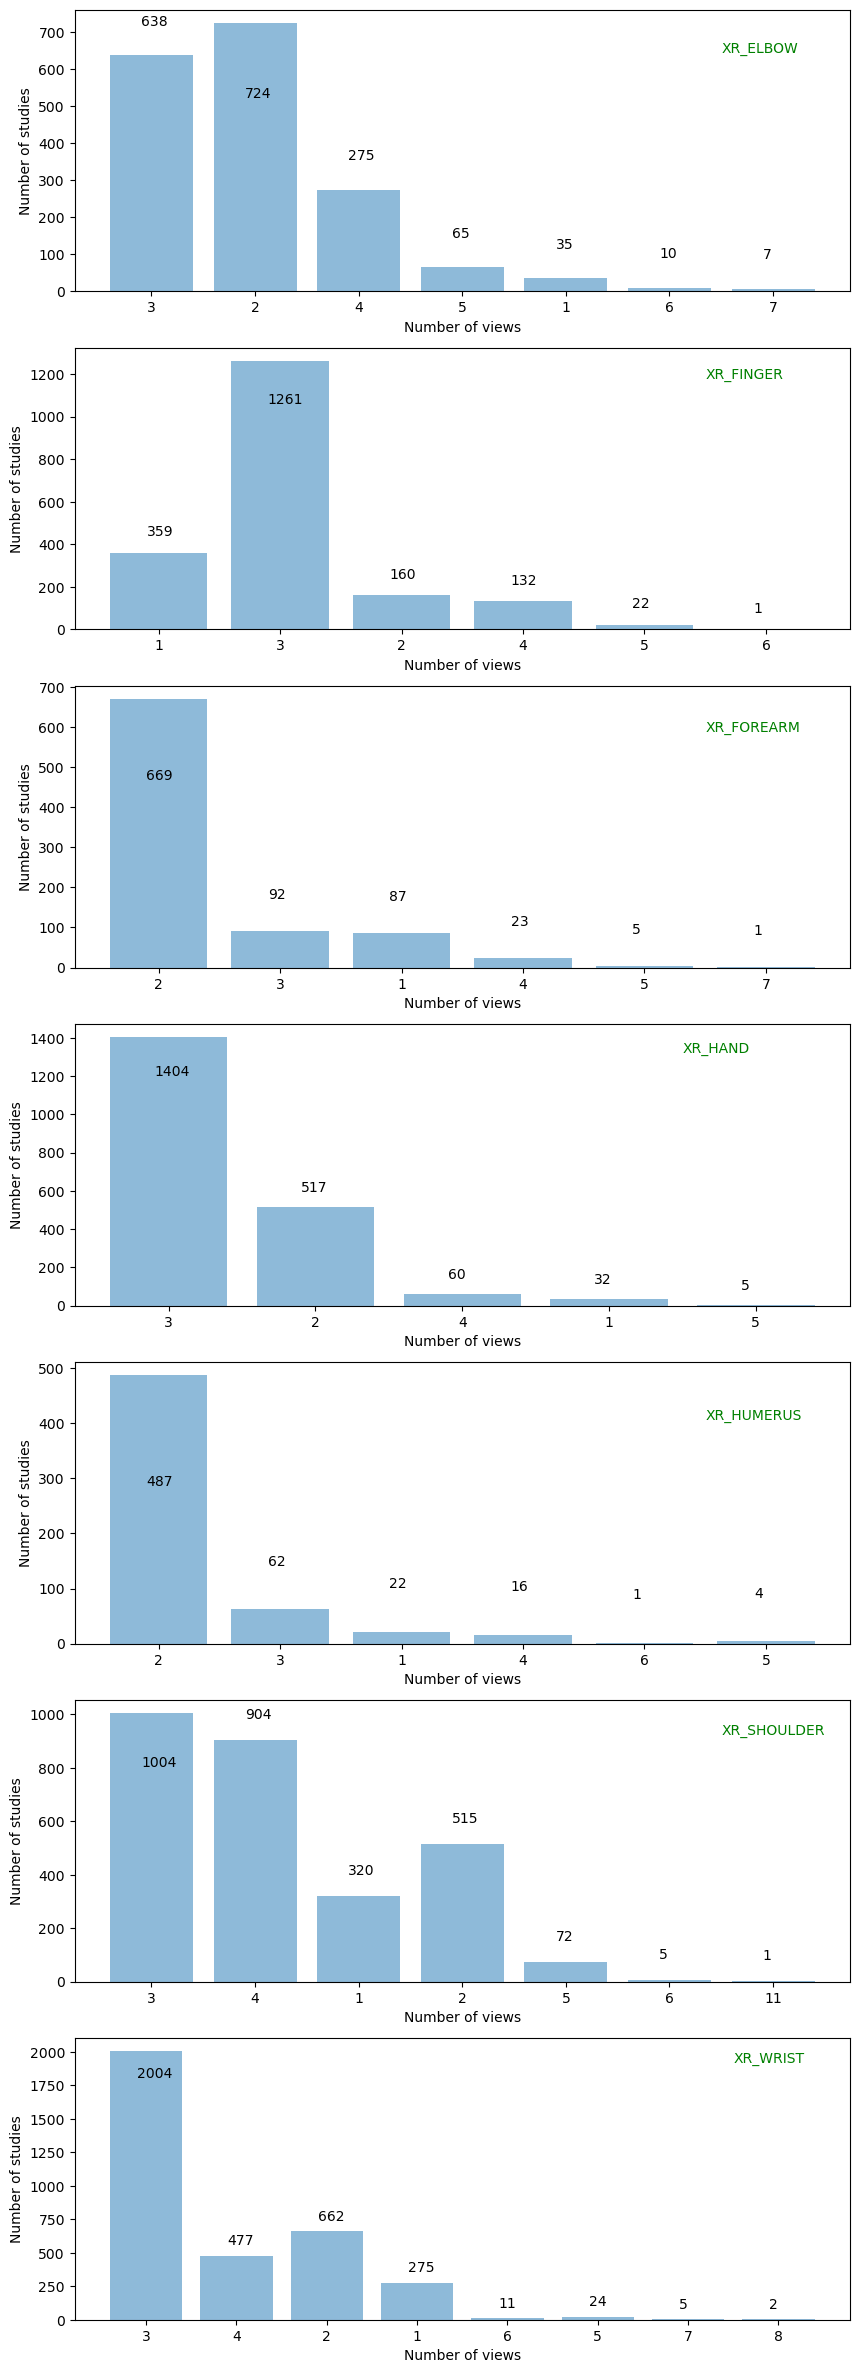

In [91]:
# plot the view count vs number of studies per study type data 
fig = plt.figure(figsize=(10, 30))
for i, view_type in enumerate(view_count):
    ax = fig.add_subplot(7, 1, i+1)
    view = view_count[view_type]
    # text in the plot
    m = max(view.values())
    for i, v in enumerate(view.values()):
        if v==m: ax.text(i-0.1, v - 200, str(v))
        else: ax.text(i-0.1, v + 80, str(v))
    ax.text(i - 0.5, m - 80, view_type, color='green')
    # plot the bar chart
    x_pos = np.arange(len(view))
    plt.bar(x_pos, view.values(), align='center', alpha=0.5)
    plt.xticks(x_pos,  view.keys())
    plt.xlabel('Number of views')
    plt.ylabel('Number of studies')
plt.show()
fig.savefig('images/nsvc.jpg', bbox_inches='tight', pad_inches=0) # name=number of studies view count

La mayoría de los estudios tiene 2, 3 o 4 vistas